In [1]:
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, BatchNormalization, Dropout, GRU
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import module
import gc
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
np.random.randint(10)

3

In [3]:
countriesOfInterest = {"HK", "JP", 'ZA', 'TN', 'TR', 'GB', 'MX', 'US', 'CO', 'EC', 'AU', 'NZ'}
countriesOfInterest = ["ZA", "EG", "TW", "JP", "DK", "FI", "US", "CA", "AU", "NZ", "BR", "CO"]
#countriesOfInterest = list(countriesOfInterest & {"ZA", "EG", "TW", "JP", "DK", "FI", "US", "CA", "AU", "NZ", "BR", "CO"})

enc = OneHotEncoder()
enc.fit(np.array(countriesOfInterest).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [4]:
seconds = 10
samplerate = 10
train_x, train_labels, val_x, val_labels, class_weights = module.getSamples(1, 1, 1, 1, seconds, samplerate, countriesOfInterest,
               enc, verbose = 0)
print("train", np.sum(train_labels, axis = 0))

train [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Fit model

In [5]:
input_shape=(train_x.shape[1], train_x.shape[2])
input_shape

(100, 25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 100, 25)           100       
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           7424      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 32)           128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                1

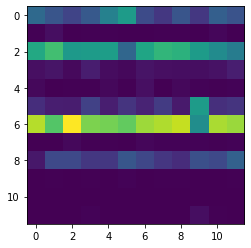

24000/24000 [==============================] - 3s 130us/sample


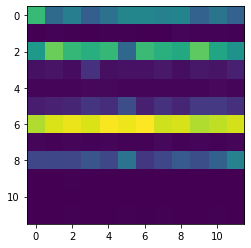

10_seconds_10_samples iteration 10
4800/4800 [==============================] - 1s 232us/sample


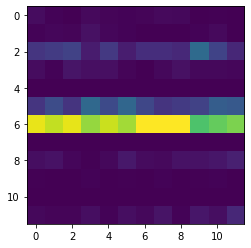

 8192/24000 [=========>....................] - ETA: 2s

KeyboardInterrupt: 

In [6]:
train_n = 100
sample_n = train_n * 20
val_n  = int(train_n/5)
valsample_n = val_n * 20
iterations = 50
epochs = 2
learn_rate = 0.001
batch_size = 4096
for D in [32, 64]:
    for LSTM2 in [32, 64]:
        for LSTM1 in [32, 64]:
            model = keras.Sequential()
            model.add(BatchNormalization(input_shape=input_shape))

            model.add(LSTM(LSTM1, 
                           input_shape=input_shape, 
                           return_sequences = True
                          ))
            model.add(BatchNormalization())
            model.add(LSTM(LSTM2, 
                           return_sequences = False,
                           go_backwards = True
                          ))
            model.add(BatchNormalization())
            model.add(Dense(D, activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
            adam = keras.optimizers.Adam(lr=0.001, amsgrad = True)
            model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
            gc.collect()
            print(model.summary())
            desc = str(LSTM1) + "_" + str(LSTM2) + "_" + str(D)
            log_dir = os.path.join(
                "logs",
                "10sec_10sample",
                desc
            )
            model_dir = os.path.join(
                "pickle",
                desc
            )


            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            model = module.train(iterations, learn_rate, train_n, sample_n, val_n, valsample_n, seconds, samplerate,
                            countriesOfInterest, enc, epochs, tensorboard_callback, model_dir,
                            model, batch_size)
            del model, model_dir, log_dir, desc, adam
            gc.collect()

In [7]:
model = keras.Sequential()
model.add(BatchNormalization(input_shape=(train_x.shape[1], train_x.shape[2])))

model.add(LSTM(128, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True
              ))
model.add(BatchNormalization())
model.add(LSTM(64, 
               return_sequences = False,
               go_backwards = True
              ))
model.add(BatchNormalization())
model.add(Dense(32, activation= "relu"))
model.add(BatchNormalization())
model.add(Dense(16, activation= "relu"))
model.add(BatchNormalization())
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.001, amsgrad = True)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
del train_x, train_labels, val_x, val_labels, class_weights
gc.collect()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 100, 25)           100       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          78848     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 128)          512       
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)               

In [ ]:
#add recurrent dropout to add noise to duration
desc = "normin_LSTM16_32_Out_1Step_001LR_amsgrad"
log_dir = os.path.join(
    "logs",
    "Overfit",
    desc
)
model_dir = os.path.join(
    "pickle",
    "save"
)

train_n = 150
sample_n = t
val_n  = int(2*train_n/5)
valsample_n = 1000
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 1
iterations = 40
learn_rate = 0.001
batch_size = 4096
model = module.train(iterations, learn_rate, train_n, sample_n, val_n, valsample_n, seconds, samplerate,
                countriesOfInterest, enc, epochs, tensorboard_callback, model_dir,
                model, batch_size)